In [1]:
import sys
import time
import numpy as np
import numba as nb
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma\SpectrumsMeasurementsLibrary"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, PathWindows)
sys.path.insert(0, LibraryPathLinux)

In [3]:
from GammaRayInteractions.Materials import Material, R
from CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices, open_detector
from NumericalMethods.simpson_rule import simpson_rule
from NumericalMethods.unfolding_technique import Gold

import matplotlib.ticker as mticker
from local_scripts import initialization_brem, generate_empty_matrix, complete_empty_matrix, integrate_the_row, get_integral_signals, apply_function_to_matrix

In [102]:
font_properties = {'family' : 'Arial', 'weight' : 'regular', 'size' : 16}
rc('font', **font_properties)

Инициализация энергетического спектра

In [5]:
beam_energy = 0.075
z_number = 50

In [6]:
brem = initialization_brem(z_number, beam_energy)

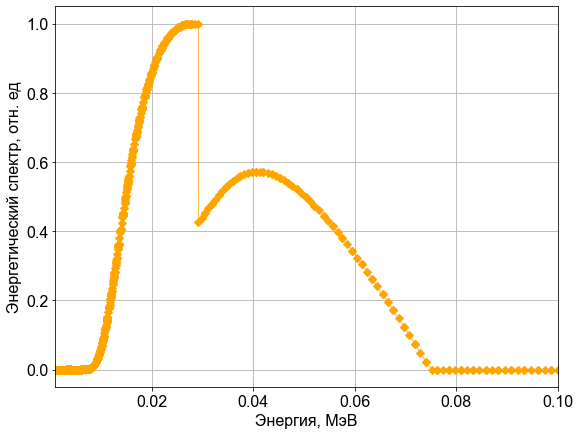

In [104]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, brem, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

# fig.savefig('Спектр.jpg', bbox_inches='tight')

Инициализация измерительных каналов

In [8]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel + 1

In [9]:
level_1 = 0.3
level_2 = 0.3

In [21]:
# создание измерительных каналов системы 1
channels_1 = [k_edge_method_transmission_function(num, level_1) for num in range(first_channel, last_channel+1)]
channels_1.insert(0, open_detector())
channels_1 = np.array(channels_1)

# создание измерительных каналов системы 2
channels_2 = np.array([k_edge_method_transmission_function(num, level_2) for num in range(first_channel, last_channel+1)])
channesl_3 = np.vstack((channels_1, channels_2))

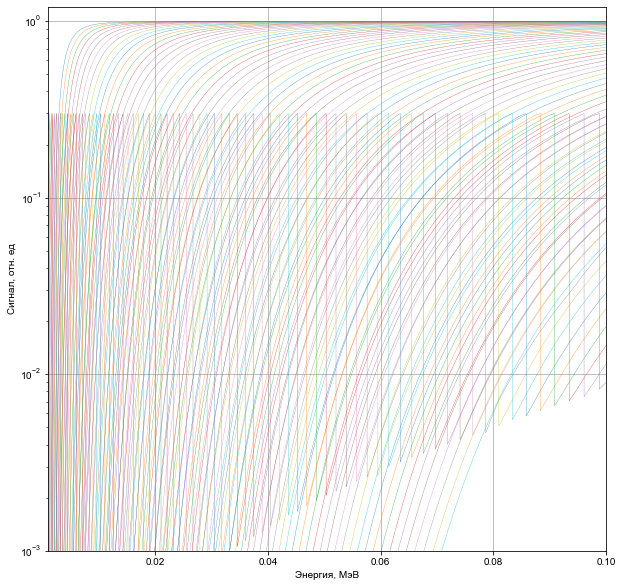

In [22]:
number_of_signals = fig, ax = plt.subplots(figsize=(10, 10))
for i in SYSTEM_1:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.3', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
ax.set_ylim(1e-3, 1.2)
ax.grid(True)

Создание матрицы с измерительной системы

In [23]:
# создание матрицы задачи
matrix1 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in channels_1])
matrix2 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in channels_2])
matrix3 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in channesl_3])

In [24]:
new_mesh = np.array(simpson_rule(SYSTEM_1[0], regime='m', function_jumps=[Material(50).k_edge_index()]))

Измерение энергетического спектра

In [25]:
signals1 = np.array([simpson_rule(r*brem) for r in channels_1])
signals2 = np.array([simpson_rule(r*brem) for r in channels_2])
signals3 = np.array([simpson_rule(r*brem) for r in channesl_3])

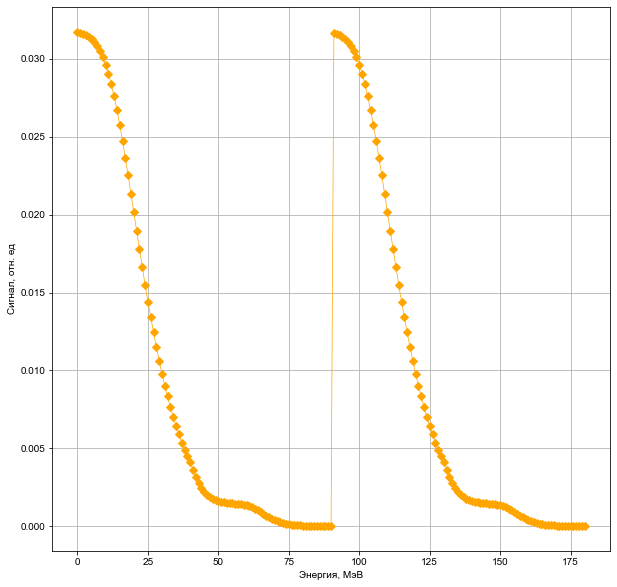

In [27]:
number_of_signals = len(signals3)
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(signals3)), signals3, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Восстановление спектра

In [28]:
bound_100_kev = Material(100).k_edge_index()

In [29]:
result = Gold(matrix1, signals1, -1, ENERGY_MESH, new_mesh, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')

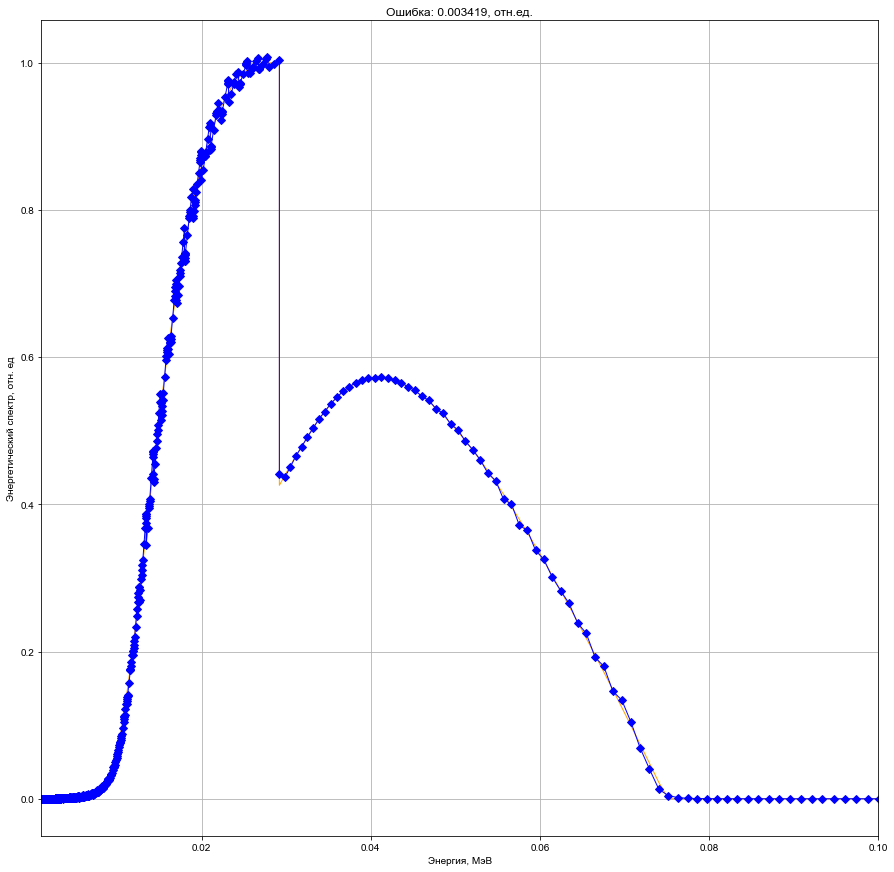

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(ENERGY_MESH, brem, ls='-', lw='1', ms=5, color='orange')
ax.plot(new_mesh, result[0], ls='-', lw='1', marker='D', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.set_title(f'Ошибка: {round(result[1], 6)}, отн.ед.')

ax.grid(True)

In [31]:
result[1]

0.0034186147559940776

Зависимость точности восстановления от обусловленности системы

In [88]:
max_level = 0.5

In [89]:
levels = np.linspace(max_level, 0.01, 15)

In [90]:
levels

array([0.5  , 0.465, 0.43 , 0.395, 0.36 , 0.325, 0.29 , 0.255, 0.22 ,
       0.185, 0.15 , 0.115, 0.08 , 0.045, 0.01 ])

In [91]:
CONDS_M2 = np.empty((len(levels)), dtype=object)
CONDS_M3 = np.empty((len(levels)), dtype=object)

SIGNALS_M2 = np.empty((len(levels)), dtype=object)
SIGNALS_M3 = np.empty((len(levels)), dtype=object)

DEVIATIONS = np.empty((len(levels)), dtype=object)

UNFOLDED_SPECTRUMS2 = np.empty((len(levels)), dtype=object)
UNFOLDED_SPECTRUMS3 = np.empty((len(levels)), dtype=object)

In [92]:
# создание измерительных каналов системы 1
system1 = [k_edge_method_transmission_function(num, max_level) for num in range(first_channel, last_channel+1)]
system1.insert(0, open_detector())
system1 = np.array([k_edge_method_transmission_function(num, max_level) for num in range(first_channel, last_channel+1)])
matrix1 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system1])
signals1 = np.array([simpson_rule(r*brem) for r in system1])

In [93]:
st = time.time()

for i, level in enumerate(levels):
    # создание измерительных каналов системы 2
    system2 = np.array([k_edge_method_transmission_function(num, level) for num in range(first_channel, last_channel+1)])
    system3 = np.vstack((system1, system2))
    
    # создание матрицы задачи
    matrix2 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system2])
    matrix3 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system3])
    
    signals2 = np.array([simpson_rule(r*brem) for r in system2])
    signals3 = np.array([simpson_rule(r*brem) for r in system3])
    
    result1 = Gold(matrix1, signals1, -1, ENERGY_MESH, new_mesh1, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
    result2 = Gold(matrix2, signals2, -1, ENERGY_MESH, new_mesh2, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
    result3 = Gold(matrix3, signals3, -1, ENERGY_MESH, new_mesh3, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
    
    CONDS_M2[i] = np.linalg.cond(matrix2)
    CONDS_M3[i] = np.linalg.cond(matrix3)
    
    SIGNALS_M2[i] = signals2
    SIGNALS_M3[i] = signals3
    
    UNFOLDED_SPECTRUMS2 = result2[0]
    UNFOLDED_SPECTRUMS3 = result3[0]
    
    DEVIATIONS[i] = result3[1]
    
    print(i, time.time()-st)

0 25.493257522583008
1 50.83357858657837
2 76.0195734500885
3 100.7104823589325
4 125.75120067596436
5 151.1324896812439
6 176.28521132469177
7 201.3354136943817
8 226.64766120910645
9 251.41816186904907
10 276.4083249568939
11 301.76569843292236
12 327.00938725471497
13 352.503543138504
14 377.4791190624237


In [99]:
np.linalg.cond(matrix1)

79502.64656103596

In [100]:
result1[1]

0.003876837855039773

In [96]:
SIGNALS_M1 = np.array([simpson_rule(r*brem) for r in system1])

In [97]:
SIGNALS_NORM = [np.linalg.norm(SIGNALS_M2[i]-SIGNALS_M1) for i in range(len(levels))]

Сохранение эксель файлов

In [98]:
from xlsxwriter.workbook import Workbook

workbook = Workbook("спектр8.xlsx")
worksheet = workbook.add_worksheet('Лист1')

worksheet.write_column(5, 2, levels)
worksheet.write_column(5, 4, CONDS_M2)
worksheet.write_column(5, 5, CONDS_M3)
worksheet.write_column(5, 7, DEVIATIONS)
worksheet.write_column(5, 8, SIGNALS_NORM)

workbook.close()

Сохранение результатов

In [160]:
# K_EDGE_METHOD_SIGNALS = np.save('СИГНАЛЫ_К_пропускание_08.npy', SIGNALS)